In [1]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [2]:
file = 'data/10km_data.csv'

data = pd.read_csv(file)
Xraw = np.array(data[['lat', 'long']])
Yraw = np.array(data['generated_temp']).reshape(-1,1)
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [3]:
true_alt, true_temps = get_alt_temp_grids(data)

In [4]:
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 0, # don't log or show plot for checking clusters vs accuracy
                    'show_plot'   : False,
                }
}

# CAUSE CLUSTER PARAMS VARIED

# number of cause clusters vs accuracy

In [8]:
n_clusters = [10, 50, 100, 150, 200, 300, 400, 500]
abs_accuracies = []
sq_accuracies = []

for n in n_clusters:
    cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n},
                         'verbose' : 0
    }

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]
    results_path = 'sample_run' # directory to save results to

    my_exp = Experiment(X_train=X,
                        Y_train=Y,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        results_path=results_path)
    results = my_exp.train()

    xlbls = results['CauseClusterer']['x_lbls']
    pred_alts = reconstruct_groups(data, xlbls, plot=False)

    abs_accuracies.append(err(true_alt, pred_alts, 'mean_abs'))
    sq_accuracies.append(err(true_alt, pred_alts, 'mean_squared'))
    print(f'abs_accuracy for {n} clusters: {abs_accuracies[-1]}')

All results from this run will be saved to sample_run\experiment0008
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
397/397 [==============================] - 0s 536us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
abs_accuracy for 10 clusters: 98.82944857946612
All results from this run will be saved to sample_run\experiment0009
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
397/397 [==============================] - 0s 589us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
abs_accuracy for 50 clusters: 89.64593068537074
All results from this run will be saved to sample_run\experiment0010
#################### Beginning CFL Experiment training. #####

Text(0.5, 1.0, 'Mean squared error vs number of clusters - 10km pixels')

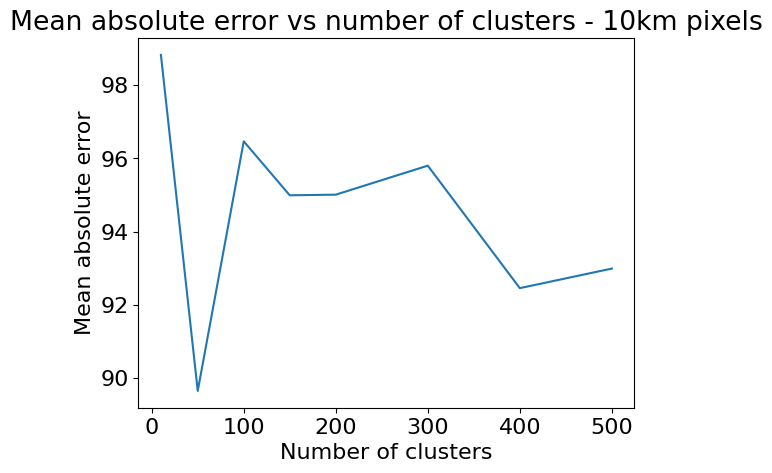

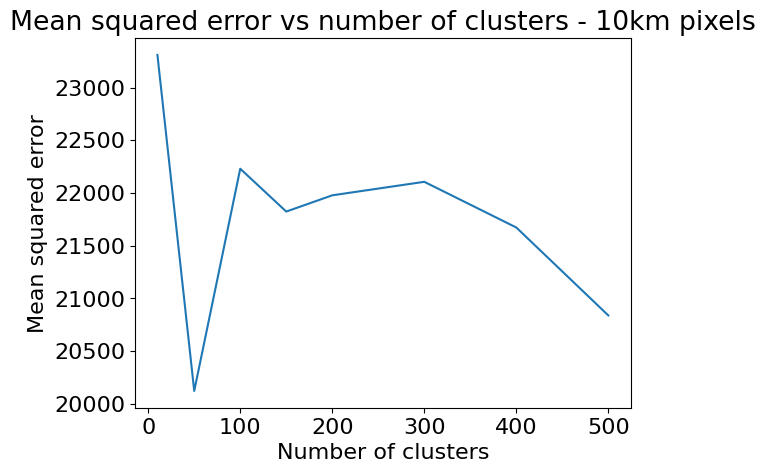

In [9]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(n_clusters, abs_accuracies)
plt.xlabel('Number of clusters')
plt.ylabel('Mean absolute error')
plt.title('Mean absolute error vs number of clusters - 10km pixels')

plt.figure(1)
plt.plot(n_clusters, sq_accuracies)
plt.xlabel('Number of clusters')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of clusters - 10km pixels')

# ABOVE GRAPHS GENERATED WITH 25KM PIXELS (2026 DATA POINTS)

# INVESTIGATE NN STRUCTURE